# Curvas Elípticas: Curva de Edward

Propostas em 2007 por _Harold M. Edwards_ em _A normal form for elliptic curves_ (Uma forma normal para curvas elípticas) são uma reformulação das curvas elípticas na forma de Weierstrass que possuem regras para adições mais simples.

As curvas são a soluções da equação:

$$x^2 + y^2 = 1 + d x^2 y^2$$

Com uma constate $d \not \in \{0, 1 \}$, os valores $(x, y, d)$ podem estar em $\mathbb{R}$ ou quando forem utilizados para criptrografia, em um conjunto $F_p$.

As adição de dois pontos $(x_1, y_1) , (x_2, y_2)$ da curva é dado por:

$$
\begin{align}
x_3 = \dfrac{x_1y_2 + x_2y_1}{1 + d x_1 x_2 y_1 y_2} \\
y_3 = \dfrac{y_1y_2 - x_1x_2}{1 - d x_1 x_2 y_1 y_2}
\end{align}
$$

Note a semelhança nos denominadores que possuem ambos o termo $d x_1 x_2 y_1 y_2$.

A seguir há uma implementação da curva de Edward tanto para reais quanto para conjuntos finitos com opções para visualização da curva.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy.ma as ma

In [205]:
def add_mod(a, b, p):
    assert a < p
    assert b < p
    
    return (a + b) % p

def mul_mod(a, b, p):
    assert a < p
    assert b < p
    
    return (a * b) % p

def sub_mod(a, b, p):
    assert a < p
    assert b < p
    
    return (a - b) % p

def inv_mod(a, p):
    for i in range(p):
        if (a * i) % p == 1:
            return i

def div_mod(a, b, p):
    assert a < p
    assert b < p
    inv = inv_mod(b, p)
    return (a * inv) % p

In [222]:
def primes(n):
    """ Returns  a list of primes < n """
    sieve = [True] * n
    for i in range(3,int(n**0.5)+1,2):
        if sieve[i]:
            sieve[i*i::2*i]=[False]*((n-i*i-1)//(2*i)+1)
    return [2] + [i for i in range(3,n,2) if sieve[i]]

def verify_square_mod(d, p):
    for i in range(p):
        if (i * i - d) % p == 0:
            return True
        
    return False

In [226]:
class EdwardCurve:
    """
    Implementation of Edward's curve (Edward's form of elliptic curves) for criptography of the form:
    x^2+ y^2 = 1 + d * x^2 * y^2       for d not  in {0, 1}

    It can be created in \mathbb{R} or in a field F_n by using the parameter "field".

    Reference:
        https://en.wikipedia.org/wiki/Edwards_curve#cite_ref-Daniel._J_Bernstein_,_Tanja_Lange_1-0
    """
    def __init__(self, d, field = None):

        assert d != 0 and d != 1

        self.d = d
        self.field = field
        self.points = []
        
        if field != None:
            assert self.verify_square_mod(d, field) == False
            
    def verify_square_mod(self, d, p):
        for i in range(p):
            if (i * i - d) % p == 0:
                return True
        return False
        
    def compute_points(self):
        """
        Compute integers solution in the group Z_n for the curve and save it in a array.
        """
        self.points = []
        limit = int((self.field - 1)/2)
        for i in range(-limit, limit + 1):
            for j in range(i, limit + 1):
                left_side = i*i + j * j
                right_side = 1 + self.d * i * i * j * j
                
                if (left_side - right_side)%self.field == 0:
                    self.points.append([i, j])
                    if i != j:
                        self.points.append([j, i])
                        
        self.points = np.array(self.points)
        
        
    def plot_real(self, ax):
        """
        Plot the function if it is defined on the reals.
        """
        
        #If d < 0, the solution of the equation is inside the square [-1, 1] X [-1, 1]
        # For the fixed value of x in [-1, 1], solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        if self.d < 0:
            xs = np.concatenate([
                np.arange(-1, -0.9, 0.01), 
                np.arange(-0.9, -0.1, 0.1),
                np.arange(-0.1, 0.1, 0.01),
                np.arange(0.1, 0.9, 0.1),
                np.arange(0.9, 1.01, 0.01)])

            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])
            ax.plot(xs, ys, label = f"d = {self.d}")

        # If d > 1, the possible x vales are on the set S = (-inf, -1) \cup (-1/d, 1/d) \cup (1, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        elif self.d > 1:
            xs = np.concatenate([np.arange(-10, -2, 1), np.arange(-2, -1.01, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])
            
            xs1 = xs.copy()
            ys1 = ys.copy()
            
            xs = np.concatenate([np.arange(1, 2, 0.01), np.arange(2, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs[::-1], xs])
            ys = np.concatenate([ys[::-1], -ys])
            
            xs2 = xs.copy()
            ys2 = ys.copy()

            xs = np.arange(-1/self.d, 1/self.d, 0.01)
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs3 = xs.copy()
            ys3 = ys.copy()
            xs4 = xs.copy()
            ys4 = -ys.copy()
            
            xs_ = ma.array(np.concatenate([xs1, xs2, xs3, xs4]))
            ys_ = ma.array(np.concatenate([ys1, ys2, ys3, ys4]))
            
            xs_[len(xs1)] = ma.masked
            xs_[len(xs1) + len(xs2)] = ma.masked
            xs_[len(xs1) + len(xs2) + len(xs3)] = ma.masked
            
            ys_[len(ys1)] = ma.masked
            ys_[len(ys1) + len(ys2)] = ma.masked
            ys_[len(ys1) + len(ys2) + len(ys3)] = ma.masked
            
            ax.plot(xs_, ys_, label = f"d = {self.d}")

        # If d in (0, 1), then 1/d > 1, so S = (-inf, -1/d)  \cup (1/d, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        else:
            
            xs = np.concatenate([np.arange(-10, -1/self.d -1, 1), np.arange(-1/self.d - 1, -1/self.d, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs1 = xs.copy()
            ys1 = ys.copy()
            xs2 = xs.copy()
            ys2 = -ys.copy()

            xs = np.concatenate([np.arange(1/self.d, 1/self.d + 1, 0.01), np.arange(1/self.d + 1, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            
            xs3 = xs.copy()
            ys3 = ys.copy()
            xs4 = xs.copy()
            ys4 = -ys.copy()
            
            xs_ = ma.array(np.concatenate([xs1, xs2, xs3, xs4]))
            ys_ = ma.array(np.concatenate([ys1, ys2, ys3, ys4]))
            
            xs_[len(xs1)] = ma.masked
            xs_[len(xs1) + len(xs2)] = ma.masked
            xs_[len(xs1) + len(xs2) + len(xs3)] = ma.masked
            
            ys_[len(ys1)] = ma.masked
            ys_[len(ys1) + len(ys2)] = ma.masked
            ys_[len(ys1) + len(ys2) + len(ys3)] = ma.masked
            
            ax.plot(xs_, ys_, label = f"d = {self.d}")
        
    def plot_finite_field(self, ax):
        """
        Plot the points of the solution set if the function is defined on a finite field.
        """
        ax.scatter(self.points[:, 0], self.points[:, 1], label = f"d = {self.d}")
        
        
        
    def plot(self, ax = None):
        """
        Controller for plotting function, call the respective function if it is defined in the reals or in a finite field.
        """
        
        if ax == None:
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_subplot(111) 
            
        if self.field == None:
            self.plot_real(ax)
        else:
            #Verify if points already computed
            if len(self.points) == 0:
                self.compute_points()
            self.plot_finite_field(ax)

    def plot_points(self, list_points, ax = None):
        
        if ax == None:
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_subplot(111) 
        
        if self.field == None:
            self.plot_real(ax)
        else:
            #Verify if points already computed
            if len(self.points) == 0:
                self.compute_points()
            self.plot_finite_field(ax)
            
        for (P, name) in list_points:
            ax.scatter(P[0], P[1], c = "#009900", s = 30, edgecolors='b', zorder = 5)
            ax.annotate(name, (P[0] + np.random.uniform(0, 0.05), P[1] + np.random.uniform(0, 0.05)))
       
        
        
    def verify_point(self, P):
        """
        Verify if a point is in a curve (satisfy equation): x^2 + y^2 = 1 + d * x^2 * y^2
        Done both in real or in a finite field.
        """
        left_side = P[0]*P[0] + P[1]*P[1]
        right_side = 1 + self.d * P[0]*P[0] *  P[1]*P[1]
        if self.field == None:
        
            return abs(left_side - right_side) < 1e-4
        else:
            return (left_side - right_side)%self.field == 0
    
        
    def add(self, P, Q, plot = False, ax = None):
        """
        Add two points from the curve P + Q = R
        """
        
        if not (self.verify_point(P) and self.verify_point(Q)):
            raise Exception("Points not in curve.")
            
        if self.field == None:
            common_term = self.d * P[0] * P[1] * Q[0] * Q[1]
        
            x = (P[0]*Q[1] + P[1]*Q[0]) / (1 + common_term)
            y = (P[1]*Q[1] - P[0]*Q[0]) / (1 - common_term)
        else:
            
            
            common_term = mul_mod(self.d, P[0], self.field)
            common_term = mul_mod(common_term, P[1], self.field)
            common_term = mul_mod(common_term, Q[0], self.field)
            common_term = mul_mod(common_term, Q[1], self.field)
            
            
            den1 = add_mod(1, common_term, self.field)
            num1 = add_mod(
                mul_mod(P[0], Q[1], self.field),
                mul_mod(P[1], Q[0], self.field),
                self.field
            )
            
            x = div_mod(num1, den1, self.field)
            
            
          
            den2 = sub_mod(1, common_term, self.field)
            num2 = sub_mod(
                mul_mod(P[1], Q[1], self.field),
                mul_mod(P[0], Q[0], self.field),
                self.field
            )
            

            y = div_mod(num2, den2, self.field)
            
            if x > np.floor(self.field/2):
                x -= self.field
            if y > np.floor(self.field/2):
                y -= self.field
                
        R = np.array([x, y])
        
        
            
        if plot:
            self.plot_points([(P, "P"), (Q, "Q"), (R, "P+Q")], ax)
            
        assert self.verify_point(R)
     
        return R
        
        
    def inverse(self, P, plot = False, ax = None):
        """
        Return the inverse point of P, i.e., the point Q such that P + Q = 0 
        """
        
        if not (self.verify_point(P)):
            raise Exception("Points not in curve.")
        
        Q = np.array([-P[0], P[1]])
        
        if plot:
            self.plot_points([(P, "P"), (Q, "- P")], ax)
            
        return Q
    
    def multiply_by_int(self, P, k, plot = False, ax = None):
        """
        Return the multiplication of point P by int value k, 
        by doing the sum P + P + \dots + P = kP
        """
        
        if not (self.verify_point(P)):
            raise Exception("Points not in curve.")
        
        list_points = []
        kP = np.array([0, 1])
        list_points.append((kP, "0P"))
        for i in range(k):
            kP = self.add(kP, P)
            list_points.append((kP, f"{i+1}P"))
            
        if plot:
            self.plot_points(list_points, ax)
            
        return kP

## Curvas nos reais

As curvas definidas em $\mathbb{R}$ possuem diferentes formas características a depender do valor de $d$. Com o valor de $x$ fixo, para compreender a curva precisamos resolver a equação quadrática:

$$ y^2(1 - d x^2) + (x^2 - 1) = 0$$

Que utilizando bhaskara, possui o valor delta:

$$ \Delta = 4(dx^2 - 1)(x^2 - 1)$$

Agora, com $d$ fixo desejamos compreender para quais valores de $x$ tem-se $\Delta > 0$. Tem-se:

- Se $d < 0$, então $\Delta > 0$ para $x \in [-1, 1]$.

- Se $d > 1$, então $\Delta > 0$ para $x \in (-\infty, -1) \cup (-1/d, 1/d) \cup (1, \infty)$.

- Se $d \in (0, 1)$, então $\Delta > 0$ para $x \in (-\infty, -1/d) \cup (1/d, \infty)$ (isto ocorre pois nesse caso $|1/d| > 1$). 

A seguir apresentamos curvas possíveis para os diferentes valores de $d$.

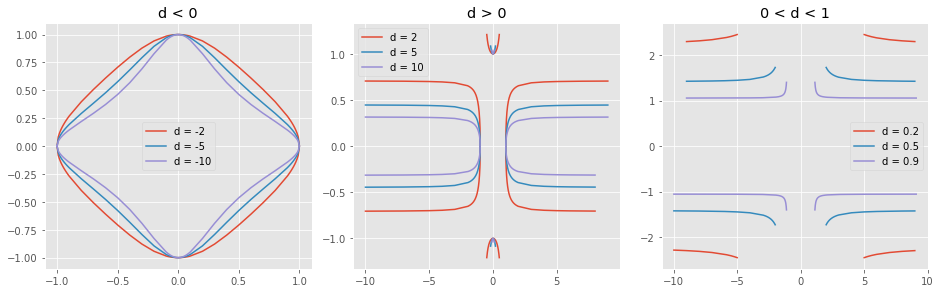

In [227]:
fig, ax = plt.subplots(figsize=(13, 4), nrows = 1, ncols = 3)
plt.tight_layout()

for d in [-2, -5, -10]:
    edc = EdwardCurve(d)
    edc.plot(ax[0])
ax[0].legend()
ax[0].set_title("d < 0")

for d in [2, 5, 10]:
    edc = EdwardCurve(d)
    edc.plot(ax[1])
ax[1].legend()
ax[1].set_title("d > 0")

for d in [0.2, 0.5, 0.9]:
    edc = EdwardCurve(d)
    edc.plot(ax[2])
ax[2].legend()
ax[2].set_title("0 < d < 1")

plt.show()

## Operações na curva

Como já mencionado anteriormente, uma das vantagens da curva de Edward é a simplicidade da soma entre dois pontos, definida por:

$$
\begin{align}
x_3 = \dfrac{x_1y_2 + x_2y_1}{1 + d x_1 x_2 y_1 y_2} \\
y_3 = \dfrac{y_1y_2 - x_1x_2}{1 - d x_1 x_2 y_1 y_2}
\end{align}
$$

É demonstrado que $1 - d x_1 x_2 y_1 y_2 > 0$ para todos pares $\{(x_1, y_1), (x_2, y_2) \}$ que satisfazem a equação da curva, logo a soma está bem definida. Além disso, vale que:

- O ponto $(x_3, y_3)$ pertence a curva.
- A adição é associativa.
- $(0, 1)$ é o elemento neutro da adição, pois: 

$$
\begin{align}
x_3 = \dfrac{x_1 \cdot 1 + 0 \cdot y_1}{1 + d x_1 \cdot 0 \cdot y_1 \cdot 1} = x_1 \\
y_3 = \dfrac{y_1 \cdot 1 - x_1 \cdot 0}{1 - d x_1 \cdot 0 \cdot y_1 \cdot 1} = y_1
\end{align}
$$

- O elemento oposto do ponto $(x_1, y_1)$ é $(-x_1, y_1)$.

Considerando a curva com $d = -30$ vamos verificar algumas ações:

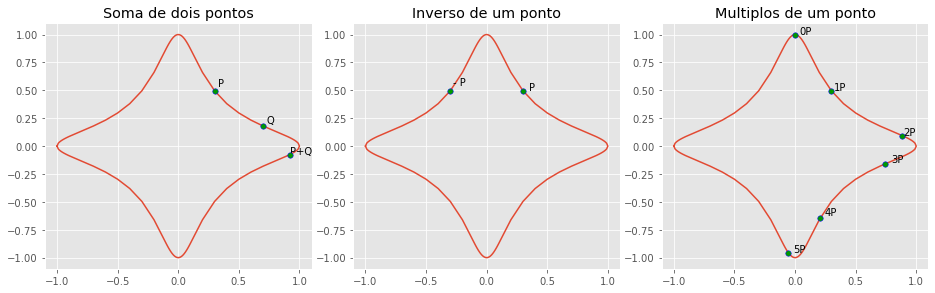

In [228]:
def solve_problem(d, x):
    delta = 4 * (d * x* x - 1) * (x * x - 1)
    y = np.sqrt(delta) / (2 * (1 - d * x * x))
    return y

P = [0.3, solve_problem(-30, 0.3)]
Q = [0.7, solve_problem(-30, 0.7)]
edc = EdwardCurve(-30)

fig, ax = plt.subplots(figsize=(13, 4), nrows = 1, ncols = 3)
plt.tight_layout()

edc.add(P, Q, plot = True, ax = ax[0])
ax[0].set_title("Soma de dois pontos")


edc.inverse(P, plot = True, ax = ax[1])
ax[1].set_title("Inverso de um ponto")

edc.multiply_by_int(P, 5, plot = True, ax = ax[2])
ax[2].set_title("Multiplos de um ponto")

plt.show()

## Curva em conjunto finito

Quanto utilizada em criptografia, a curva é definida em um conjunto finito de inteiros, geralmente para algum primo $p$, utiliza-se o conjunto $\mathbb{Z}_p$, no entanto $p$ não deve ser $2$. Para representar a curva centralizada na origem, utilizamos o conjunto $\mathbb{Z}_p$ centralizado em $0$, por exemplo, $Z_5 = \{-2, -1, 0, 1, 2\}$.

A seguir iremos desenhar a curva para diferentes valores de $d$ e utilizando $p = 43$, no entanto, note que uma maneira fácil de encontrar todas as soluções da equação é a partir de testar todos os pares $(x, y) \in \mathbb{Z}_{43}$, o que pode ser feito de forma rápida com esse valor de $p$.

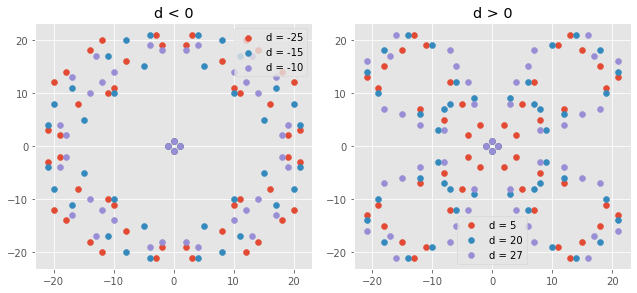

In [234]:
fig, ax = plt.subplots(figsize=(9, 4), nrows = 1, ncols = 2)
plt.tight_layout()


for d in [-25, -15, -10]:
    edc = EdwardCurve(d, p)
    edc.plot(ax[0])
ax[0].legend()
ax[0].set_title("d < 0")

for d in [5, 20, 27]:
    edc = EdwardCurve(d, 43)
    edc.plot(ax[1])
ax[1].legend()
ax[1].set_title("d > 0")

plt.show()

## Operações na curva

As operações na curva definidas anteriormente se mantém as mesmas, no entanto agora realizaremos somas e multiplicações operando em $\mod p$. Novamente podemos visualizar alguns exemplos considerando $p = 43, d = -30$.

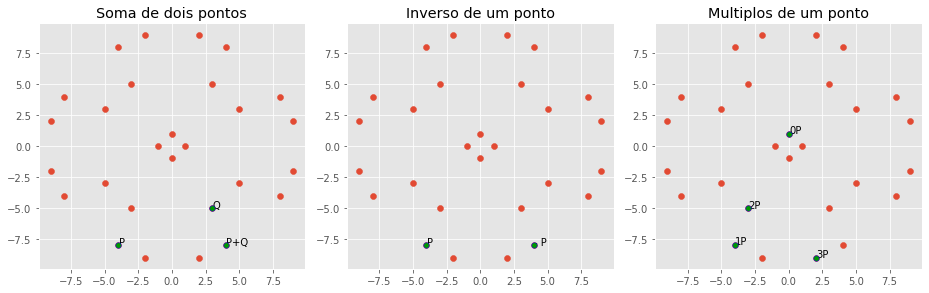

In [235]:
def solve_problem_field(d, x, field):
    solutions = []
    limit = int((field - 1)/2)
    j = x
    for i in range(-limit, limit + 1):
        left_side = i*i + j * j
        right_side = 1 + d * i * i * j * j
        if (left_side - right_side)%field == 0:
            return i

d = -30
p = 19
edc = EdwardCurve(d, p)
edc.compute_points()
n_points = len(edc.points)

P = edc.points[np.random.randint(n_points)]
Q = edc.points[np.random.randint(n_points)]

fig, ax = plt.subplots(figsize=(13, 4), nrows = 1, ncols = 3)
plt.tight_layout()

edc.add(P, Q, plot = True, ax = ax[0])
ax[0].set_title("Soma de dois pontos")


edc.inverse(P, plot = True, ax = ax[1])
ax[1].set_title("Inverso de um ponto")

edc.multiply_by_int(P, 3, plot = True, ax = ax[2])
ax[2].set_title("Multiplos de um ponto")

plt.show()